## 1. Time Series Classification

In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import os
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

### (a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\ %29 . The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. Each file containis 6 time series collected from activities of the same person. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

Answer (a) -> Downloaded the data set

### (b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

Answer (b) -> Done the train-test split

### (c) Feature Extraction : Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

### i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

Answer i. -> Some of the time-domain features used in time-series classification are:
1. Number of positive/negative peaks in a time series
2. Coefficient of Kurtosis
3. Coefficient of Skewness
4. Mean value of the time series
5. Minimum value of the time series
6. Maximum value of the time series
7. Median value of the time series
8. Autoregressive component of the time series 
9. Moving average component of the time series
10. Range of the time series
11. Inter-quartile range of the time series
12. 10th percentile of the time series

### ii. Extract the time-domain features for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly

### Extracting (Mean,Min,Max,Median,10th Percentile, Range) for all 6 time series

### Creating the train set

In [238]:
d_train = {}
params = ['mean','min','max','median','p10','range']
var = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
for v in var:
    for p in params:
        d_train[v+"_"+p] = []
d_train['activity'] = []

In [239]:
for activity in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
    path = '/Users/nikmag/Desktop/USC/INF_552_ML/HW2/AReM_1/{0}/train'.format(activity)
    for filename in os.listdir(path):
        df = pd.read_csv(path+'/'+filename,skiprows=4)
        for v in var:
            d_train[v+"_"+"mean"].append(np.mean(df[v]))
            d_train[v+"_"+"min"].append(np.min(df[v]))
            d_train[v+"_"+"max"].append(np.max(df[v]))
            d_train[v+"_"+"median"].append(np.median(df[v]))
            d_train[v+"_"+"p10"].append(np.percentile(df[v],10))
            d_train[v+"_"+"range"].append(np.max(df[v])-np.min(df[v]))
        d_train['activity'].append(activity)

### Creating the test set

In [240]:
d_test = {}
params = ['mean','min','max','median','p10','range']
var = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
for v in var:
    for p in params:
        d_test[v+"_"+p] = []
d_test['activity'] = []

In [241]:
for activity in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
    path = '/Users/nikmag/Desktop/USC/INF_552_ML/HW2/AReM_1/{0}/test'.format(activity)
    for filename in os.listdir(path):
        df = pd.read_csv(path+'/'+filename,skiprows=4)
        for v in var:
            d_test[v+"_"+"mean"].append(np.mean(df[v]))
            d_test[v+"_"+"min"].append(np.min(df[v]))
            d_test[v+"_"+"max"].append(np.max(df[v]))
            d_test[v+"_"+"median"].append(np.median(df[v]))
            d_test[v+"_"+"p10"].append(np.percentile(df[v],10))
            d_test[v+"_"+"range"].append(np.max(df[v])-np.min(df[v]))
        d_test['activity'].append(activity)

In [242]:
df_train = pd.DataFrame(d_train)
df_test = pd.DataFrame(d_test)

### Combining the train and test sets for bootstrap sampling

In [243]:
df = pd.concat([df_train,df_test],ignore_index=True)

### iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a bootsrap confidence interval for the standard deviation of each feature.

### Calculating the standard deviation

In [9]:
df_bootstrap = df.describe()[df.describe().index == 'std']

### Using Bootstrap to find 95% Confidence Interval

In [10]:
d_ci1 = {k:object for k in df.columns.tolist()}
d_ci2 = {k:object for k in df.columns.tolist()}

In [11]:
for col in df.columns.tolist():
    bootstrap = []
    for i in range(0,1000):
        sample = np.random.choice(df[col],size=88,replace=True)
        bootstrap.append(np.std(sample))
    bootstrap.sort()
    d_ci1[col] = bootstrap[24]
    d_ci2[col] = bootstrap[974]

In [12]:
df_bootstrap.loc['Confidence Interval_2.5%',:] = d_ci1
df_bootstrap.loc['Confidence Interval_97.5%',:] = d_ci2

In [13]:
df_bootstrap = df_bootstrap.T

In [14]:
df_bootstrap.rename(columns={'std':'Standard Deviation Estimate'},inplace=True)

In [15]:
df_bootstrap

,Standard Deviation Estimate,Confidence Interval_2.5%,Confidence Interval_97.5%
avg_rss12_max,4.394362,3.086221,5.503041
avg_rss12_mean,5.335718,4.600517,5.941605
avg_rss12_median,5.440054,4.621198,6.011958
avg_rss12_min,9.569975,8.000321,10.945635
avg_rss12_p10,6.779123,5.965771,7.317881
avg_rss12_range,9.713457,8.197083,10.897441
avg_rss13_max,4.875137,4.057135,5.523297
avg_rss13_mean,4.008380,3.291098,4.495014
avg_rss13_median,4.036396,3.325134,4.550776
avg_rss13_min,2.956462,2.717210,3.115735


### iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

In [37]:
df.describe()

,avg_rss12_max,avg_rss12_median,avg_rss12_p10,avg_rss13_max,avg_rss13_median,avg_rss13_p10,avg_rss23_max,avg_rss23_median,avg_rss23_p10,var_rss12_max,var_rss12_median,var_rss12_p10,var_rss13_max,var_rss13_median,var_rss13_p10,var_rss23_max,var_rss23_median,var_rss23_p10
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,45.473068,38.856705,35.186477,22.810909,14.613352,9.526511,24.320114,16.239602,11.487455,6.290114,1.288068,0.394284,6.761250,1.313352,0.394432,6.461932,1.445511,0.469545
std,4.394362,5.440054,6.779123,4.875137,4.036396,4.299485,5.741238,5.813782,6.070124,5.062729,1.412244,0.569894,2.183625,1.145586,0.559581,2.518921,1.086474,0.553815
min,30.000000,24.250000,20.750000,11.330000,4.500000,1.000000,12.000000,2.250000,0.000000,0.430000,0.000000,0.000000,2.490000,0.000000,0.000000,1.790000,0.430000,0.000000
25%,44.585000,35.447500,28.500000,21.000000,12.740000,7.000000,21.000000,13.447500,8.235250,1.767500,0.430000,0.000000,5.165000,0.470000,0.000000,4.500000,0.500000,0.000000
50%,45.750000,39.415000,36.000000,23.500000,15.330000,11.290000,23.500000,16.125000,11.987500,4.500000,0.500000,0.000000,6.070000,0.500000,0.000000,6.310000,0.830000,0.000000
75%,47.750000,43.250000,41.270000,25.580000,16.690000,12.000000,25.500000,17.812500,13.062500,10.930000,2.185000,0.820000,9.000000,2.860000,1.000000,8.765000,2.615000,1.090000
max,56.250000,48.000000,48.000000,35.000000,23.000000,18.000000,40.330000,36.000000,32.500000,17.240000,4.260000,1.790000,11.420000,3.200000,1.480000,13.610000,3.340000,1.410000


Answer iv. -> Using the following 3 variables for further analysis:

1. Maximum value - To capture the peak of the time series
2. Median value - To capture central tendancy and also because mean can be sensitive to outliers
3. Bottom 10th Percentile value - To capture bottoms of the time series, cannot use minimum value because it makes variables like var_rss13_min 0. Hence, such variables lose their meaning

## (d) Binary Classification Using Logistic Regression

### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 120 of the textbook).2

In [244]:
cols = [col for col in df.columns.tolist() if col.endswith('p10') or col.endswith('median') or col.endswith('max') or col == 'activity']

In [245]:
df = df[cols]

In [248]:
df_train = df.iloc[0:69,:]
df_test = df.iloc[69:,:]

In [249]:
df_train['activity'] = np.where(((df_train['activity'] == 'bending1')|(df_train['activity'] == 'bending2')),'bending','not-bending')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [250]:
df_test['activity'] = np.where(((df_test['activity'] == 'bending1')|(df_test['activity'] == 'bending2')),'bending','not-bending')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [256]:
cols = [col for col in df.columns.tolist() if col.startswith('avg_rss12') or col.startswith('var_rss12') or col.startswith('var_rss23') or col == 'activity']

In [257]:
df_train_i = df_train[cols]

In [278]:
df_temp = pd.DataFrame('a',columns=['col'],index=[i for i in range(0,621)])

In [279]:
df_temp['val'] = 0
df_temp['activity'] = 'b'

In [280]:
j = 0
k = 1
for col in df_train_i.columns.tolist()[1:]:
    for i in range(0,69):
        df_temp.loc[j,'val'] = df_train_i.loc[i,col]
        df_temp.loc[j,'col'] = str(k)
        j = j + 1
    k = k + 1

In [281]:
j = 0
for i in range(0,621):
    df_temp.loc[i,'activity'] = df_train_i.loc[j,'activity']
    j = j + 1
    if j == 69:
        j=0

In [282]:
df_temp['activity_int'] = np.where(df_temp['activity'] == 'bending',1,0)

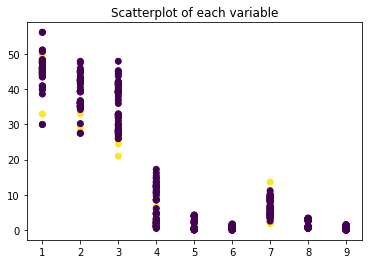

In [283]:
a=plt.scatter(df_temp['col'],df_temp['val'],c=df_temp['activity_int'],)
plt.title('Scatterplot of each variable')
plt.show()

Answer i. -> The scatterplot shows bending in colour yellow and not bending in colour purple. This shows an imbalanced class distribution

### ii. Break each time series in your training set into two (approximately) equal length time series and repeat the experiment in 1(d)i. Do you see any con- siderable difference in the results with those of 1(d)i?

In [291]:
d_train = {}
params = ['max','median','p10']
var = ['avg_rss12','var_rss12','var_rss23']
for v in var:
    for p in params:
        d_train[v+"_"+p] = []
d_train['activity'] = []

In [292]:
for activity in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
    path = '/Users/nikmag/Desktop/USC/INF_552_ML/HW2/AReM_1/{0}/train'.format(activity)
    for filename in os.listdir(path):
        df = pd.read_csv(path+'/'+filename,skiprows=4)
        df_l = np.array_split(df,2)
        for l in df_l:
            for v in var:
                d_train[v+"_"+"max"].append(np.max(l[v]))
                d_train[v+"_"+"median"].append(np.median(l[v]))
                d_train[v+"_"+"p10"].append(np.percentile(l[v],10))
            d_train['activity'].append(activity)

In [293]:
df_train = pd.DataFrame(d_train)

In [297]:
df_train['activity'] = np.where(((df_train['activity'] == 'bending1')|(df_train['activity'] == 'bending2')),'bending','not-bending')

In [303]:
df_temp = pd.DataFrame('a',columns=['col'],index=[i for i in range(0,1242)])

In [304]:
df_temp['val'] = 0
df_temp['activity'] = 'b'

In [306]:
j = 0
k = 1
for col in df_train.columns.tolist()[1:]:
    for i in range(0,138):
        df_temp.loc[j,'val'] = df_train.loc[i,col]
        df_temp.loc[j,'col'] = str(k)
        j = j + 1
    k = k + 1

In [308]:
j = 0
for i in range(0,1242):
    df_temp.loc[i,'activity'] = df_train.loc[j,'activity']
    j = j + 1
    if j == 138:
        j=0

In [309]:
df_temp['activity_int'] = np.where(df_temp['activity'] == 'bending',1,0)

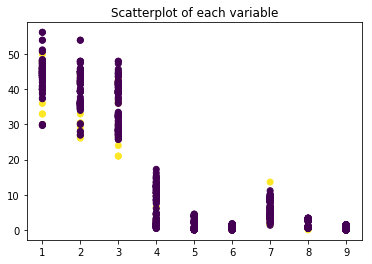

In [310]:
a=plt.scatter(df_temp['col'],df_temp['val'],c=df_temp['activity_int'])
plt.title('Scatterplot of each variable')
plt.show()

Answer ii. -> There is not a considerable difference between the two scatterplots

### iii. Break each time series in your training set into l ∈ {1, 2, . . . , 10}3 time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Calculate the p-values for your logistic regression parameters and refit a logistic regression model using your pruned set of features.4 Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to de- termine the best value of l. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way!

### Breaking each time series in the training set into L = {1,2,3,....,10,11,....,20} and performing Logistic Regression to build the binary classification models using 5-Fold cross validation 

In [2]:
d={}
d1 = {}
params = ['max','median','p10']
var1 = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
for l in range(1,21):
    d_train = {}
    for v in var1:
        for p in params:
            d_train[v+"_"+p] = []
    d_train['activity'] = []
    
    for activity in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
        path = '/Users/nikmag/Desktop/USC/INF_552_ML/HW2/AReM_1/{0}/train'.format(activity)
        for filename in os.listdir(path):
            df = pd.read_csv(path+'/'+filename,skiprows=4)
            df_l = np.array_split(df,l)
            for li in df_l:
                for v in var1:
                    d_train[v+"_"+"max"].append(np.max(li[v]))
                    d_train[v+"_"+"median"].append(np.median(li[v]))
                    d_train[v+"_"+"p10"].append(np.percentile(li[v],10))
                d_train['activity'].append(activity)
    df_train = pd.DataFrame(d_train)
    df_train['activity'] = np.where(((df_train['activity'] == 'bending1')|(df_train['activity'] == 'bending2')),'bending','not-bending')
    
    df_train = df_train.sample(frac=1,random_state=123).reset_index(drop=True)
    X = df_train.loc[:,df_train.columns!='activity']
    y = df_train['activity']
    
    auc1 = []
    l1 = []
    l2 = []
    
    kf = KFold(n_splits=5)
    
    for train_index,val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index.tolist(),:], X.iloc[val_index.tolist(),:]
        y_train, y_val = y[train_index.tolist()], y[val_index.tolist()]
        if len(np.unique(y_val)) == 1:
            continue
            
        model = LogisticRegression()
        model = model.fit(X_train, y_train)
        actual = [1 if i == 'bending' else 0 for i in y_val.tolist()]
        predicted = [1 if i == 'bending' else 0 for i in model.predict(X_val).tolist()]
        fpr, tpr, _ = roc_curve(actual,predicted)
        auc1.append(auc(fpr, tpr))
        l1.append(train_index.tolist())
        l2.append(val_index.tolist())
    d[l] = tuple(zip(auc1,l1,l2))
    d1[l] = np.mean(auc1)

In [3]:
iii = pd.DataFrame(d1,index=[0])
iii = iii.T
iii['L'] = iii.index
iii.rename(columns={0:'Mean AUC across the folds'},inplace=True)
iii = iii[['L','Mean AUC across the folds']]

In [4]:
iii

,L,Mean AUC across the folds
1,1,0.937500
2,2,0.913612
3,3,0.833032
4,4,0.855649
5,5,0.870229
6,6,0.866632
7,7,0.854921
8,8,0.861374
9,9,0.876329
10,10,0.844960


### Finding the best subset of features on the dataset using Backward selection and 5-fold cross validation for best L = 1

In [9]:
L = 1
d_train = {}
for v in var1:
    for p in params:
        d_train[v+"_"+p] = []
d_train['activity'] = []

for activity in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
    path = '/Users/nikmag/Desktop/USC/INF_552_ML/HW2/AReM_1/{0}/train'.format(activity)
    for filename in os.listdir(path):
        df = pd.read_csv(path+'/'+filename,skiprows=4)
        df_l = np.array_split(df,L)
        for li in df_l:
            for v in var1:
                d_train[v+"_"+"max"].append(np.max(li[v]))
                d_train[v+"_"+"median"].append(np.median(li[v]))
                d_train[v+"_"+"p10"].append(np.percentile(li[v],10))
            d_train['activity'].append(activity)
df_train = pd.DataFrame(d_train)
df_train['activity'] = np.where(((df_train['activity'] == 'bending1')|(df_train['activity'] == 'bending2')),'bending','not-bending')
df_train = df_train.sample(frac=1,random_state=123).reset_index(drop=True)
X = df_train.loc[:,df_train.columns!='activity']
y = df_train['activity']

auc1 = []
variables = []
l1 = []
l2 = []

kf = KFold(n_splits=5)

for train_index,val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index.tolist(),:], X.iloc[val_index.tolist(),:]
    y_train, y_val = y[train_index.tolist()], y[val_index.tolist()]
    if len(np.unique(y_val)) == 1:
        continue

    # Implementing Backward Selection (Recursive Feature Elimination)

    svc = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=svc, n_features_to_select=6, step=1,verbose=0)

    # Subsetting features for each fold

    feature_subset = rfe.fit(X_train, y_train).ranking_ == 1
    X_train = X_train.loc[:,feature_subset]
    X_val = X_val.loc[:,feature_subset]
    
    # Fitting Logistic Regression and reporting AUC for each fold
    model = LogisticRegression()
    model = model.fit(X_train, y_train)
    actual = [1 if i == 'bending' else 0 for i in y_val.tolist()]
    predicted = [1 if i == 'bending' else 0 for i in model.predict(X_val).tolist()]
    fpr, tpr, _ = roc_curve(actual,predicted)
    auc1.append(auc(fpr, tpr))
    variables.append(X_train.columns.tolist())
    l1.append(train_index.tolist())
    l2.append(val_index.tolist())
d = tuple(zip(auc1,variables,l1,l2))

In [31]:
d

((0.75,
  ['avg_rss12_p10',
   'avg_rss13_median',
   'avg_rss23_max',
   'avg_rss23_median',
   'avg_rss23_p10',
   'var_rss23_max'],
  [14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]),
 (1.0,
  ['avg_rss12_max',
   'avg_rss13_median',
   'avg_rss13_p10',
   'avg_rss23_max',
   'avg_rss23_p10',
   'var_rss23_max'],
  [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,

Answer iii. -> The best value of L is 1 according to the analysis and has a mean AUC of 0.937 across all folds. The correct way of performing cross validation in this scenario is to find the best L. After finding the best L, run 5-fold cross validation again to find the best feature subset by running the logistic regression model with a different subset of features on each fold.

### iv. Report the confusion matrix and show the ROC and AUC for your classifier. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

### Running the previous Logistic Regression Model with Best value of L = 1 and the features that gave the best AUC (1.0) in cross validation with same Random State (Seed is set = 123)

In [23]:
L = 1
feature_subset = d[1][1]
train_index = d[1][2]
val_index = d[1][3]
d_train = {}
for v in var1:
    for p in params:
        d_train[v+"_"+p] = []
d_train['activity'] = []

for activity in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
    path = '/Users/nikmag/Desktop/USC/INF_552_ML/HW2/AReM_1/{0}/train'.format(activity)
    for filename in os.listdir(path):
        df = pd.read_csv(path+'/'+filename,skiprows=4)
        df_l = np.array_split(df,L)
        for li in df_l:
            for v in var1:
                d_train[v+"_"+"max"].append(np.max(li[v]))
                d_train[v+"_"+"median"].append(np.median(li[v]))
                d_train[v+"_"+"p10"].append(np.percentile(li[v],10))
            d_train['activity'].append(activity)
df_train = pd.DataFrame(d_train)
df_train['activity'] = np.where(((df_train['activity'] == 'bending1')|(df_train['activity'] == 'bending2')),'bending','not-bending')
df_train = df_train.sample(frac=1,random_state=123).reset_index(drop=True)
X = df_train.loc[:,df_train.columns!='activity']
X = X[feature_subset]
y = df_train['activity']

In [24]:
X_train, X_val = X.iloc[train_index,:], X.iloc[val_index,:]
y_train, y_val = y[train_index], y[val_index]

In [25]:
model = LogisticRegression()
model = model.fit(X_train, y_train)
actual = [1 if i == 'bending' else 0 for i in y_val.tolist()]
predicted = [1 if i == 'bending' else 0 for i in model.predict(X_val).tolist()]

### Printing the confusion matrix

In [26]:
cm = metrics.confusion_matrix(actual,predicted)
print(cm)

[[13  0]
 [ 0  1]]


Note -> 
Horizontally - actual values
Vertically - predicted values

### ROC curve and AUC

In [27]:
fpr, tpr, _ = roc_curve(actual,predicted)
roc_auc = auc(fpr, tpr)

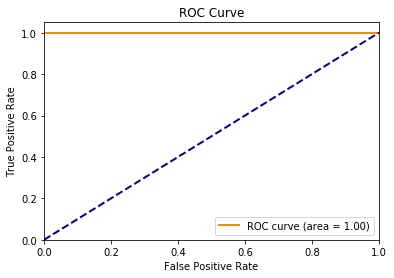

In [28]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Coefficient values

In [29]:
coef = pd.DataFrame({"Variable Name":feature_subset,"Coefficient value":model.coef_[0].tolist()})
coef[['Variable Name','Coefficient value']]

,Variable Name,Coefficient value
0,avg_rss12_max,0.630658
1,avg_rss13_median,0.462090
2,avg_rss13_p10,0.089272
3,avg_rss23_max,-0.887104
4,avg_rss23_p10,-0.722843
5,var_rss23_max,-0.030620


### P Values

In [321]:
#P Values

,Variable Name,P Value
0,avg_rss12_max,4.957838e-01
1,avg_rss13_median,2.713352e-02
2,avg_rss13_p10,1.465119e-01
3,avg_rss23_max,7.707013e-13
4,avg_rss23_p10,7.895976e-15
5,var_rss23_max,6.132177e-02


### v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

### Creating the test set for the best value of L = 1

In [141]:
L = 1
d_test = {}
for v in var1:
    for p in params:
        d_test[v+"_"+p] = []
d_test['activity'] = []

for activity in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
    path = '/Users/nikmag/Desktop/USC/INF_552_ML/HW2/AReM_1/{0}/test'.format(activity)
    for filename in os.listdir(path):
        df = pd.read_csv(path+'/'+filename,skiprows=4)
        df_l = np.array_split(df,L)
        for li in df_l:
            for v in var1:
                d_test[v+"_"+"max"].append(np.max(li[v]))
                d_test[v+"_"+"median"].append(np.median(li[v]))
                d_test[v+"_"+"p10"].append(np.percentile(li[v],10))
            d_test['activity'].append(activity)
df_test = pd.DataFrame(d_test)
df_test['activity'] = np.where(((df_test['activity'] == 'bending1')|(df_test['activity'] == 'bending2')),'bending','not-bending')

### Subsetting features of both train and test set

In [325]:
feature_subset.append('activity')

In [326]:
df_train = df_train[feature_subset]
df_test = df_test[feature_subset]

### Fitting Logistic Regression on the train set and checking AUC on the test set

In [64]:
X_train = df_train.loc[:,df_train.columns!='activity']
y_train = df_train['activity']
X_test = df_test.loc[:,df_test.columns!='activity']
y_test = df_test['activity']

model = LogisticRegression()
model = model.fit(X_train, y_train)
actual = [1 if i == 'bending' else 0 for i in y_test.tolist()]
predicted = [1 if i == 'bending' else 0 for i in model.predict(X_test).tolist()]

cm = metrics.confusion_matrix(actual,predicted)
print("Confusion Matrix for the test set: ")
print(cm)

fpr, tpr, _ = roc_curve(actual,predicted)
roc_auc = auc(fpr, tpr)
print("AUC for the test set: ")
print(roc_auc)

Confusion Matrix for the test set: 
[[15  0]
 [ 2  2]]
AUC for the test set: 
0.75


The AUC for the model on the test set is 0.75, whereas on the cross validation set it was 1.0, for the subset of features and L = 1

### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Answer vi. -> No, the classes are not distributed evenly in each of the folds in cross validation. To alleviate this problem, as you can see in the codes, I randomly shuffled the dataset so that each training fold could get atleast 4 minority classes for L = 1, and so on for greater values of L. Due to this method I incorporated, I was able to reduce the problem of instability of logistic regression parameters. There were some test folds in cross validation, that did not even have one observation of the minority class. As this fold was useless, I ignored it's validation error. The class imbalance problem for L = 1 was also seen while incorporating this on the test set. The test set had only 4 minority class observations and this caused the model to give only an AUC of 0.75 (as opposed to 1.0 in the validation set), even for the best 6 features that I selected.

### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

### Bulding a Logistic Regression model with balanced classes by adjusting class_weight = balanced

In [328]:
X_train = df_train.loc[:,df_train.columns!='activity']
y_train = df_train['activity']
X_test = df_test.loc[:,df_test.columns!='activity']
y_test = df_test['activity']

model = LogisticRegression(class_weight='balanced')
model = model.fit(X_train, y_train)
actual = [1 if i == 'bending' else 0 for i in y_test.tolist()]
predicted = [1 if i == 'bending' else 0 for i in model.predict(X_test).tolist()]

cm = metrics.confusion_matrix(actual,predicted)
print("Confusion Matrix for the test set: ")
print(cm)

fpr, tpr, _ = roc_curve(actual,predicted)
roc_auc = auc(fpr, tpr)
print("AUC for the test set: ")
print(roc_auc)

Confusion Matrix for the test set: 
[[15  0]
 [ 1  3]]
AUC for the test set: 
0.875


### ROC Curves

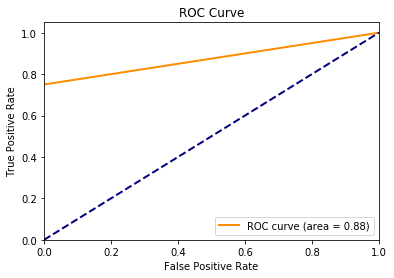

In [329]:
fpr, tpr, _ = roc_curve(actual,predicted)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Answer vii. -> Yes, a lot of class imbalance has been observed in the confusion matrices. The event rate of the minority samples was as low as 13%. After balancing the class weights, the AUC increased from 0.75 to 0.875.

## (e) Binary Classification Using L1-penalized logistic regression

### i. Repeat 1(d)iii using L1-penalized logistic regression, i.e. instead of using p- values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and C, the weight of L1 penalty in your logistic regression objective function. Packages usually perform cross-validation for C automatically.

### Stratified Cross validation both on L and C (set by default to be ten values in a logarithmic scale between 1e-4 and 1e4 by sklearn) and Normalizing each feature to [0,1] scale

In [134]:
d={}
params = ['max','median','p10']
var1 = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
for l in range(1,21):
    d_train = {}
    for v in var1:
        for p in params:
            d_train[v+"_"+p] = []
    d_train['activity'] = []
    
    for activity in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
        path = '/Users/nikmag/Desktop/USC/INF_552_ML/HW2/AReM_1/{0}/train'.format(activity)
        for filename in os.listdir(path):
            df = pd.read_csv(path+'/'+filename,skiprows=4)
            df_l = np.array_split(df,l)
            for li in df_l:
                for v in var1:
                    d_train[v+"_"+"max"].append(np.max(li[v]))
                    d_train[v+"_"+"median"].append(np.median(li[v]))
                    d_train[v+"_"+"p10"].append(np.percentile(li[v],10))
                d_train['activity'].append(activity)
    df_train = pd.DataFrame(d_train)
    df_train['activity'] = np.where(((df_train['activity'] == 'bending1')|(df_train['activity'] == 'bending2')),'bending','not-bending')
    
    df_train = df_train.sample(frac=1,random_state=123).reset_index(drop=True)
    X = df_train.loc[:,df_train.columns!='activity']
    y = df_train['activity']
    
    #Normalizing each feature to [0,1] scale
    
    for col in X.columns.tolist():
        X[col] = X[col].apply(lambda x: (x-np.min(X[col]))/(np.max(X[col]-np.min(X[col]))))
    
    auc1 = []
    best_c = []
    
    kf = StratifiedKFold(n_splits=5)
    
    for train_index,val_index in kf.split(X,y):
        X_train, X_val = X.iloc[train_index.tolist(),:], X.iloc[val_index.tolist(),:]
        y_train, y_val = y[train_index.tolist()], y[val_index.tolist()]
        if len(np.unique(y_val)) == 1:
            continue
            
        model = LogisticRegressionCV(Cs=10,penalty='l1',solver='liblinear')
        model = model.fit(X_train, y_train)
        actual = [1 if i == 'bending' else 0 for i in y_val.tolist()]
        predicted = [1 if i == 'bending' else 0 for i in model.predict(X_val).tolist()]
        fpr, tpr, _ = roc_curve(actual,predicted)
        auc1.append(auc(fpr, tpr))
        best_c.append(model.C_)
    d[l] = tuple(zip(auc1,best_c))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [136]:
auc1 = []
C = []
for i in d.keys():
    for j in range(0,5):
        auc1.append(d[i][j][0])
for i in d.keys():
    for j in range(0,5):
        C.append(d[i][j][1][0])

### Visualizing best performance

In [153]:
a = pd.DataFrame({"L":list(np.repeat(list(d.keys()),5)),"CV AUC":auc1,"Optimal C":C})
a[['L','Optimal C','CV AUC']]

,L,Optimal C,CV AUC
0,1,2.782559,1.000000
1,1,2.782559,0.500000
2,1,21.544347,0.958333
3,1,2.782559,1.000000
4,1,166.810054,1.000000
5,2,166.810054,0.979167
6,2,21.544347,0.875000
7,2,10000.000000,0.875000
8,2,166.810054,0.979167
9,2,21.544347,0.958333


### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

### Implementing best result on test set (L=1 and C = 166.810054)

In [144]:
X_train = df_train.loc[:,df_train.columns!='activity']
y_train = df_train['activity']
X_test = df_test.loc[:,df_test.columns!='activity']
y_test = df_test['activity']

model = LogisticRegression(penalty='l1',C=166.810054,solver='liblinear')
model = model.fit(X_train, y_train)
actual = [1 if i == 'bending' else 0 for i in y_test.tolist()]
predicted = [1 if i == 'bending' else 0 for i in model.predict(X_test).tolist()]

cm = metrics.confusion_matrix(actual,predicted)
print("Confusion Matrix for the test set: ")
print(cm)

fpr, tpr, _ = roc_curve(actual,predicted)
roc_auc = auc(fpr, tpr)
print("AUC for the test set: ")
print(roc_auc)

Confusion Matrix for the test set: 
[[15  0]
 [ 0  4]]
AUC for the test set: 
1.0


In [148]:
a = pd.DataFrame({"Variable Selection Method":['Backward Selection','L1-penalization'],"Optimum L value":[1,1],"Test AUC":[0.75,1.0],"Notes":["None","C = 166.81"]})
a[['Variable Selection Method','Optimum L value','Test AUC','Notes']]

,Variable Selection Method,Optimum L value,Test AUC,Notes
0,Backward Selection,1,0.75,None
1,L1-penalization,1,1.00,C = 166.81


Answer ii. -> The L1 penalization method significantly outperforms the backward-selection method implemented before for the same value of L

I have implemented L1-penalized method and Backward selection method. It is much easier to implement L1 penalized method as compared to p-value method because you just have to add one L1 regularization term in the loss function and it is programmatically easier to implement as well.

## (f) Multi-class Classification (The Realistic Case)

### i. Use the best L you found6 from 1(e)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

### I will be using Stratified KFold Cross Validation to to test the multiclass model and find the best L and feature subset

In [245]:
d={}
params = ['max','median','p10']
var1 = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
for l in range(1,21):
    d_train = {}
    for v in var1:
        for p in params:
            d_train[v+"_"+p] = []
    d_train['activity'] = []
    
    for activity in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
        path = '/Users/nikmag/Desktop/USC/INF_552_ML/HW2/AReM_1/{0}/train'.format(activity)
        for filename in os.listdir(path):
            df = pd.read_csv(path+'/'+filename,skiprows=4)
            df_l = np.array_split(df,l)
            for li in df_l:
                for v in var1:
                    d_train[v+"_"+"max"].append(np.max(li[v]))
                    d_train[v+"_"+"median"].append(np.median(li[v]))
                    d_train[v+"_"+"p10"].append(np.percentile(li[v],10))
                d_train['activity'].append(activity)
    df_train = pd.DataFrame(d_train)
    df_train = df_train.sample(frac=1,random_state=123).reset_index(drop=True)
    X = df_train.loc[:,df_train.columns!='activity']
    y = df_train['activity']
    
    #Normalizing each feature to [0,1] scale
    
    for col in X.columns.tolist():
        X[col] = X[col].apply(lambda x: (x-np.min(X[col]))/(np.max(X[col]-np.min(X[col]))))
    
    auc1 = []
    best_c = []
    
    kf = StratifiedKFold(n_splits=5)
    
    for train_index,val_index in kf.split(X,y):
        X_train, X_val = X.iloc[train_index.tolist(),:], X.iloc[val_index.tolist(),:]
        y_train, y_val = y[train_index.tolist()], y[val_index.tolist()]
        if len(np.unique(y_val)) == 1:
            continue
            
        model = LogisticRegressionCV(Cs=10,penalty='l1',solver='liblinear')
        model = model.fit(X_train, y_train)
        act = pd.DataFrame({k:[] for k in ['bending1','bending2','cycling','lying','sitting','standing','walking']})
        j = 0
        for i in list(model.predict(X_test)):
            act.loc[j,i] = 1
            act.loc[j,act.columns!=i] = 0
            j = j + 1
        for col in act.columns.tolist():
            act[col] = act[col].apply(int)
        y_pred = np.array(act)
        y_test1 = np.array(pd.get_dummies(y_test))
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(0,7):
            fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        auc1.append(np.mean(list(roc_auc.values())))
        best_c.append(model.C_)
    d[l] = tuple(zip(auc1,best_c))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Got optimal AUC for L = 18

### Creating train and test sets for L = 18 to test multiclass logistic regression model

In [250]:
L = 18
d_test = {}
for v in var1:
    for p in params:
        d_test[v+"_"+p] = []
d_test['activity'] = []

for activity in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
    path = '/Users/nikmag/Desktop/USC/INF_552_ML/HW2/AReM_1/{0}/test'.format(activity)
    for filename in os.listdir(path):
        df = pd.read_csv(path+'/'+filename,skiprows=4)
        df_l = np.array_split(df,L)
        for li in df_l:
            for v in var1:
                d_test[v+"_"+"max"].append(np.max(li[v]))
                d_test[v+"_"+"median"].append(np.median(li[v]))
                d_test[v+"_"+"p10"].append(np.percentile(li[v],10))
            d_test['activity'].append(activity)
df_test = pd.DataFrame(d_test)

L = 18
d_train = {}
for v in var1:
    for p in params:
        d_train[v+"_"+p] = []
d_train['activity'] = []

for activity in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
    path = '/Users/nikmag/Desktop/USC/INF_552_ML/HW2/AReM_1/{0}/train'.format(activity)
    for filename in os.listdir(path):
        df = pd.read_csv(path+'/'+filename,skiprows=4)
        df_l = np.array_split(df,L)
        for li in df_l:
            for v in var1:
                d_train[v+"_"+"max"].append(np.max(li[v]))
                d_train[v+"_"+"median"].append(np.median(li[v]))
                d_train[v+"_"+"p10"].append(np.percentile(li[v],10))
            d_train['activity'].append(activity)
df_train = pd.DataFrame(d_train)

### Implementing best result on test set (L=18)

In [268]:
X_train = df_train.loc[:,df_train.columns!='activity']
y_train = df_train['activity']
X_test = df_test.loc[:,df_test.columns!='activity']
y_test = df_test['activity']

model = LogisticRegression(penalty='l1',solver='liblinear',)
model = model.fit(X_train, y_train)

d = {'bending1':0,'bending2':1,'cycling':2,'lying':3,'sitting':4,'standing':5,'walking':6}

y_true = [d[i] for i in list(y_test)]
y_pred = [d[i] for i in list(model.predict(X_test))]


### Printing the confusion matrix

In [273]:
confusion_matrix(y_true, y_pred)

array([[36,  0,  0,  0,  0,  0,  0],
       [ 3, 26,  3,  0,  4,  0,  0],
       [ 0,  0, 54,  0,  0,  0,  0],
       [ 0,  2,  1, 51,  0,  0,  0],
       [ 2,  1,  0,  3, 36, 12,  0],
       [ 0,  0,  0,  7, 13, 34,  0],
       [ 0,  0,  3,  0,  0,  0, 51]])

### Plotting ROC curve for each class

In [277]:
act = pd.DataFrame({k:[] for k in ['bending1','bending2','cycling','lying','sitting','standing','walking']})
j = 0
for i in list(model.predict(X_test)):
    act.loc[j,i] = 1
    act.loc[j,act.columns!=i] = 0
    j = j + 1
for col in act.columns.tolist():
    act[col] = act[col].apply(int)
y_pred = np.array(act)
y_test1 = np.array(pd.get_dummies(y_test))
fpr = {}
tpr = {}
roc_auc = {}
for i in range(0,7):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

### Mean AUC for all 7 classes

In [286]:
np.mean(list(roc_auc.values()))

0.90868152816682246

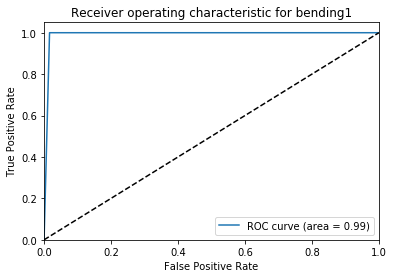

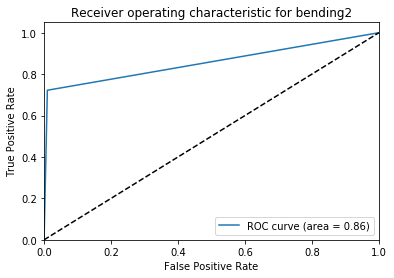

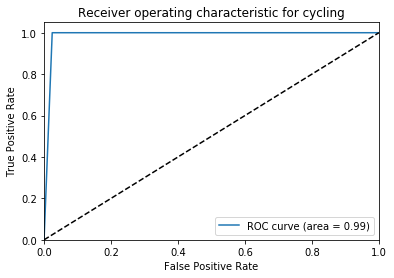

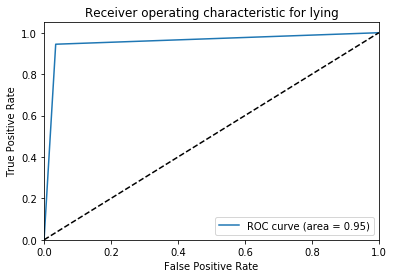

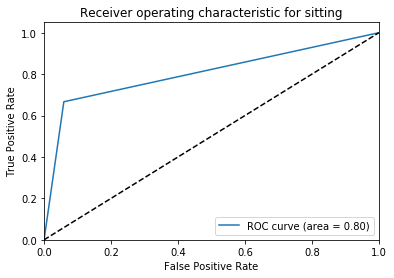

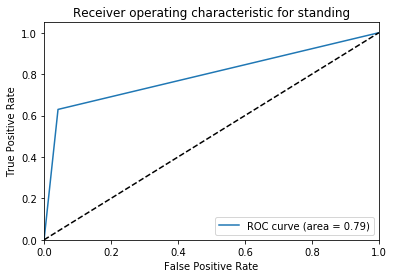

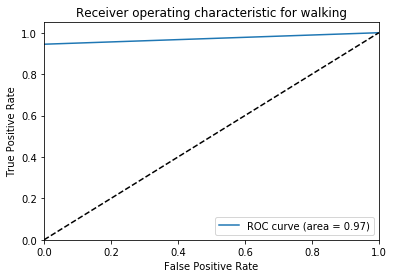

In [279]:
j = 0
for i in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
    plt.figure()
    plt.plot(fpr[j], tpr[j], label='ROC curve (area = %0.2f)' % roc_auc[j])
    j = j + 1
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

Answer i. -> Confusion matrices can be plotted easily for multiclass classification problems and is shown above. ROC curves and their AUC for each class have been plotted above. ROC curves can be plotted by binarizing the output.

### ii. Repeat 1(f)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multi- nomial priors and compare the results.

### Implementing Gaussian Naive Bayes

In [291]:
gnb = GaussianNB() 
y_pred = [d[i] for i in list(gnb.fit(X_train, y_train).predict(X_test))]

### Confusion matrix

In [292]:
confusion_matrix(y_true, y_pred)

array([[36,  0,  0,  0,  0,  0,  0],
       [ 0, 36,  0,  0,  0,  0,  0],
       [ 0,  0, 53,  0,  0,  0,  1],
       [ 0,  6,  0, 48,  0,  0,  0],
       [ 4,  0,  0,  0, 28, 22,  0],
       [ 2,  0,  0,  2,  9, 41,  0],
       [ 0,  0,  2,  0,  0,  0, 52]])

### Plotting ROC curves

In [295]:
act = pd.DataFrame({k:[] for k in ['bending1','bending2','cycling','lying','sitting','standing','walking']})
j = 0
for i in list(gnb.fit(X_train, y_train).predict(X_test)):
    act.loc[j,i] = 1
    act.loc[j,act.columns!=i] = 0
    j = j + 1
for col in act.columns.tolist():
    act[col] = act[col].apply(int)
y_pred = np.array(act)
y_test1 = np.array(pd.get_dummies(y_test))
fpr = {}
tpr = {}
roc_auc = {}
for i in range(0,7):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

### Mean AUC for 7 classes

In [296]:
np.mean(list(roc_auc.values()))

0.92477824463118574

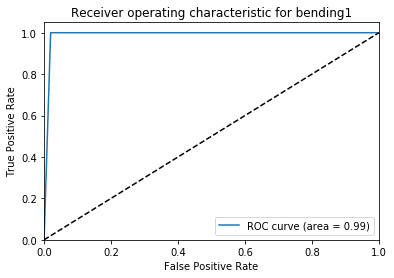

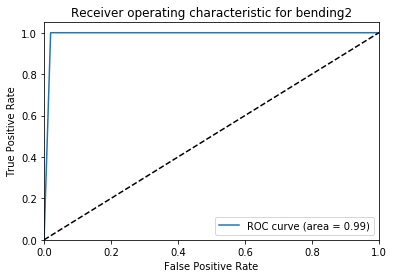

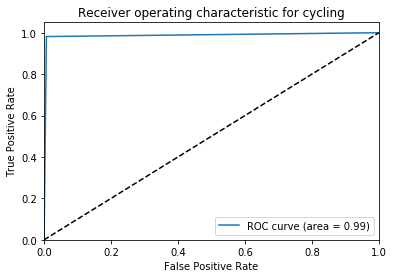

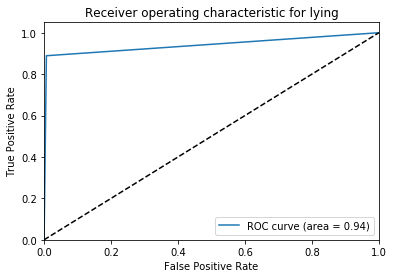

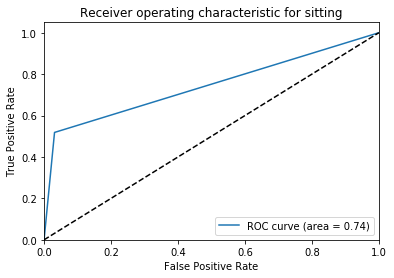

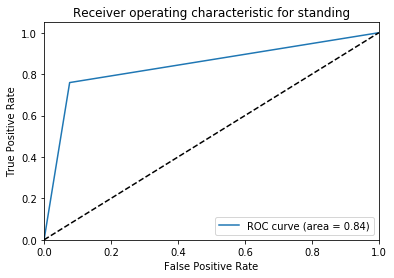

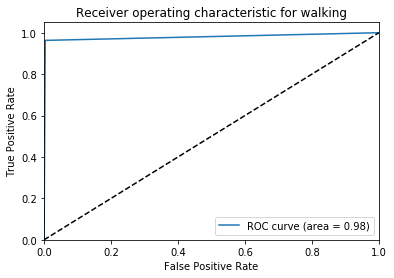

In [297]:
j = 0
for i in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
    plt.figure()
    plt.plot(fpr[j], tpr[j], label='ROC curve (area = %0.2f)' % roc_auc[j])
    j = j + 1
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

### Implementing Multinomial Naive Bayes

In [298]:
mnb = MultinomialNB() 
y_pred = [d[i] for i in list(mnb.fit(X_train, y_train).predict(X_test))]

### Confusion Matrix

In [299]:
confusion_matrix(y_true, y_pred)

array([[36,  0,  0,  0,  0,  0,  0],
       [20, 11,  4,  0,  1,  0,  0],
       [ 0,  0, 53,  0,  0,  0,  1],
       [ 0,  2,  1, 45,  4,  2,  0],
       [ 1,  1,  1,  4, 34, 13,  0],
       [ 0,  0,  0, 10, 22, 22,  0],
       [ 0,  0,  3,  0,  0,  0, 51]])

### Plotting ROC curve

In [300]:
act = pd.DataFrame({k:[] for k in ['bending1','bending2','cycling','lying','sitting','standing','walking']})
j = 0
for i in list(mnb.fit(X_train, y_train).predict(X_test)):
    act.loc[j,i] = 1
    act.loc[j,act.columns!=i] = 0
    j = j + 1
for col in act.columns.tolist():
    act[col] = act[col].apply(int)
y_pred = np.array(act)
y_test1 = np.array(pd.get_dummies(y_test))
fpr = {}
tpr = {}
roc_auc = {}
for i in range(0,7):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

### Mean AUC for all 7 classes

In [301]:
np.mean(list(roc_auc.values()))

0.84244670090258322

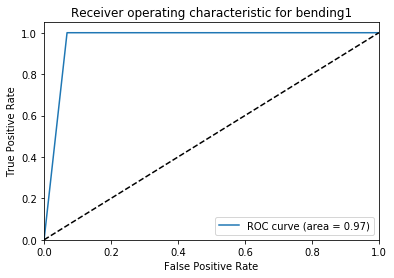

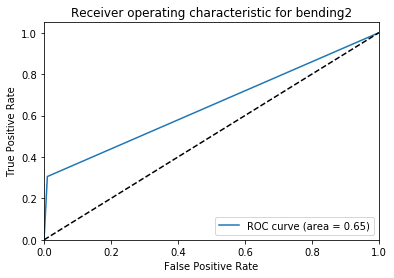

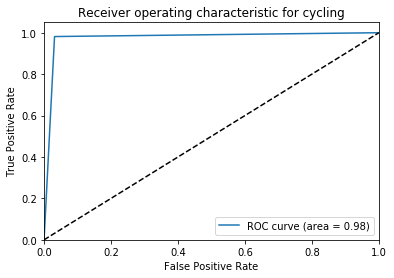

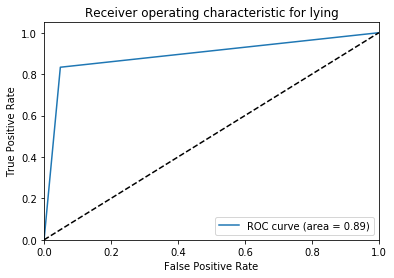

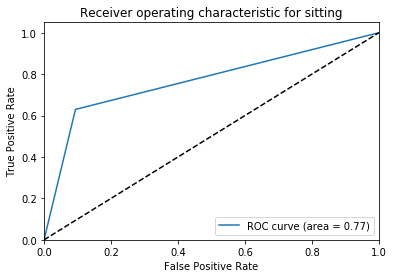

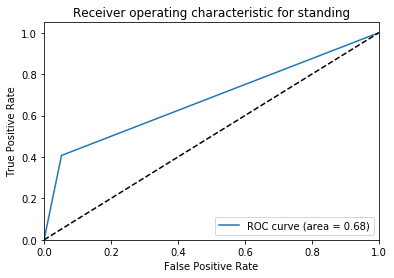

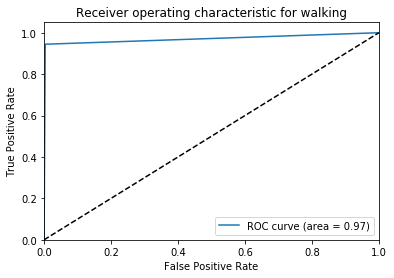

In [302]:
j = 0
for i in ['bending1','bending2','cycling','lying','sitting','standing','walking']:
    plt.figure()
    plt.plot(fpr[j], tpr[j], label='ROC curve (area = %0.2f)' % roc_auc[j])
    j = j + 1
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

### iii. Which method is better for multi-class classification in this problem?

In [307]:
a = pd.DataFrame({"Method":["L1 penalized Multinomial Logistic Regression","Gaussian NB","Multinomial NB"],"Mean AUC for all 7 classes":[.908,0.924,0.842]})
a[['Method','Mean AUC for all 7 classes']]

,Method,Mean AUC for all 7 classes
0,L1 penalized Multinomial Logistic Regression,0.908
1,Gaussian NB,0.924
2,Multinomial NB,0.842


Answer iii. -> The best method for multi-class classification problem is Gaussian NB with AUC = 0.924